In [1]:
using Turing
using StatsPlots

```javascript
var locationPrior = function() {
  if (flip(.55)) {
    return 'popular-bar';
  } else {
    return 'unpopular-bar';
  }
};

var alice = function() {
  return Infer({ model() {
    var myLocation = locationPrior();
    return myLocation;
  }});
};

viz(alice());
```

In [2]:
P = 0.55

@model function alice0()
	myLocation ~ Bernoulli(P)
end

alice0 (generic function with 1 method)

Sampling: 100%|█████████████████████████████████████████| Time: 0:00:00


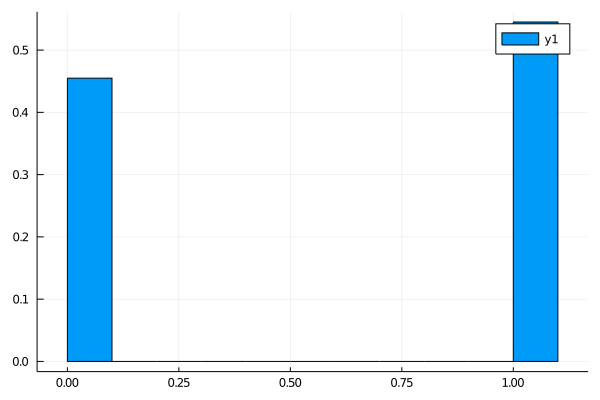

In [35]:
N = 10000
INFALG = IS()
# INFALG = MH()
# INFALG = PG(10)

#  Run sampler, collect results
chn0 = sample(alice0(), INFALG, N)

# Plot the results
function plotChn(chn)
    histogram(chn[:myLocation], weights=exp.(chn[:lp]), normalize=:probability)
end
plotChn(chn0)

```javascript
var alice = function() {
  return Infer({ model() {
    var myLocation = locationPrior();
    var bobLocation = sample(bob());
    condition(myLocation === bobLocation);
    return myLocation;
  }});
};

var bob = function() {
  return Infer({ model() {
    var myLocation = locationPrior();
    return myLocation;
  }});
};

viz(alice());
```

In [36]:
PDIRAC = 0.95

@model function alice1(bobChn)
    myLocation ~ Bernoulli(P)
    weights = exp.(bobChn[:lp][:, 1])
    idx ~ Categorical(weights/sum(weights))
    # Dirac can be used, but Bernoulli will give better convergence
    bobChn[:myLocation][idx, 1] ~ Bernoulli(myLocation ? PDIRAC : 1 - PDIRAC) # Dirac(myLocation)
end    
   

@model function bob1()
    myLocation ~ Bernoulli(P)
end

bob1 (generic function with 1 method)

Sampling: 100%|█████████████████████████████████████████| Time: 0:00:00
Sampling: 100%|█████████████████████████████████████████| Time: 0:00:04


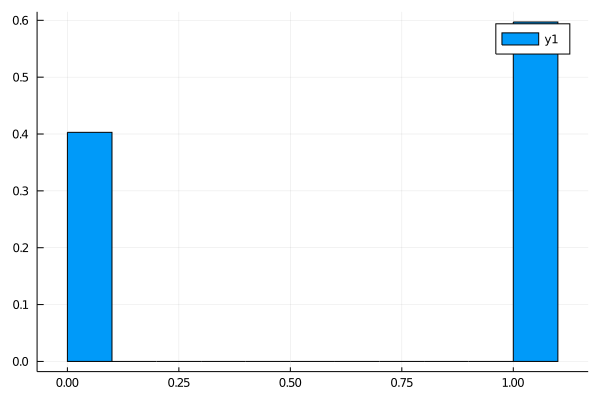

In [37]:
#  Run sampler, collect results
bobChn = sample(bob1(), INFALG, N)
chn1 = sample(alice1(bobChn), INFALG, N)

plotChn(chn1)